### Objective

Plot the footprint (incoherent tune shift) in the presence of amplitude detuning.

**1) Definitions**
The computation of the tune shift is done analytically using the following formulas

\begin{equation}
    \Delta Q_x = 2(\alpha_{xx}J_x + \alpha_{xy}J_y) \\
    \Delta Q_y = 2(\alpha_{yy}J_y + \alpha_{xy}J_x)
\end{equation}


where $\alpha_{yy}$, $\alpha_{xx}$ and $\alpha_{xy}=\alpha_{yx}$ are the detuning coefficients with units 1/m.

The actions are computed as follows.

\begin{equation}\label{eq:action}
    J_y = \frac{1}{2}(y_n^2 +yp^2_n) 
\end{equation}
and 
\begin{equation}\label{normalised_y}
    y_n = \frac{y}{\sqrt{\beta_y}}, \ \ yp_n = \frac{\alpha_y y}{\sqrt{\beta_y}} + \sqrt{\beta_y}yp
\end{equation}
the normalised coordinates and $\alpha_y, \beta_y$ the twiss parameters. 
The same applies for the x-plane. 



Definitions: https://www.overleaf.com/project/5fce701453f1700b5514e926


**2) The initial distribution is a grid of 900 particles in x and y planes**

- Grid up to 3 $\sigma_{x,y}=3\sigma_{J_{x,y}}$ of the gaussian beam used in the long tracking simulations.

- The particles are equally spaced in action.

**3) Apply condition for realistic postion of particles**

The probability of particles to have very large Jx and Jy at the same time is very small.
Thus, when plotting the footprint we apply the following condition:

\begin{equation}
\frac{Jx}{Jx_{max}} + \frac{Jy}{Jy_{max}} \geq 1
\end{equation}

Using this condition we should obtain the familiar triangular footprint.

**4) Cross check with tracking**

- The synchrotron motion should be frozen. 
- Just comment out the longitudinal map

**5) Compute also the coherent tune shift**

From the motion of the centroid.

### 1) Imports

In [25]:
#==========================================================
#                       Imports
#==========================================================
from __future__ import division

import os, sys, time
import h5py as hp
import numpy as np
import matplotlib.pyplot as plt
import pickle
import csv

import NAFFlib as pnf

# Added by Themis
import scipy
#sys.path.append('/Applications/anaconda/pkgs/')
#sys.path.append('/nfsbigdata1/tmastorigrp/src/')

from scipy.constants import m_p, c, e
from mpl_toolkits.mplot3d import Axes3D

from PyHEADTAIL.particles.slicing import UniformBinSlicer
from PyHEADTAIL.particles.generators import generate_Gaussian6DTwiss 
from PyHEADTAIL.trackers.detuners import Chromaticity, AmplitudeDetuning
from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
from PyHEADTAIL.trackers.simple_long_tracking import RFSystems, LinearMap
from PyHEADTAIL.monitors.monitors import BunchMonitor, SliceMonitor, ParticleMonitor
from PyHEADTAIL.feedback.transverse_damper import TransverseDamper
from PyHEADTAIL.impedances.wakes import CircularResonator, WakeTable, WakeField


sys.path.append('../../utils')
from coordinatesConversions import *
from cmpt_TuneSpreads import *

%matplotlib inline

In [26]:
params = {'legend.fontsize': 20,
          'figure.figsize': (8, 7),
          'axes.labelsize': 25,
          'axes.titlesize': 21,
          'xtick.labelsize': 23,
          'ytick.labelsize': 23,
          'image.cmap': 'jet',
          'lines.linewidth': 2,
          'lines.markersize': 7,
          'font.family': 'sans-serif'}


plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

In [27]:
plt.close('all')

## 2) Study parameters

In [28]:
#==========================================================
#           Variables We (Usually) Do Not Change
#==========================================================

gamma = 287.8
p0 = m_p*c*np.sqrt(gamma**2 - 1)
beta = np.sqrt(1 - 1/gamma**2)
circumference = 6911.5623
frev = 299792458/circumference


# PARAMETERS FOR TRANSVERSE MAP
# =====================
n_segments = 1
s = np.arange(0, n_segments+1)*circumference/n_segments
# optics at CC2
alpha_x = 0 * np.ones(n_segments)  # -0.9120242128
beta_x = 30.31164764 * np.ones(n_segments)
D_x = 0 * np.ones(n_segments) # -0.4954033073
alpha_y = 0 * np.ones(n_segments)  # 1.862209583
beta_y = 73.81671646 * np.ones(n_segments)
D_y = 0 * np.ones(n_segments)


Q_x, Q_y = 26.13, 26.18
Qp_x, Qp_y = 0.5, 0.5 #10

# detuning coefficients in (1/m)
app_x = 153.8183853 
app_xy = -416.0175086  
app_y = -50.03699877 

# PARAMETERS FOR LONGITUDINAL MAP
# =======================
alpha = 1.9e-3
Q_s = 0.0051
h1, h2 = 4620, 9240
V1, V2 = 5.008e6, 0e6
dphi1, dphi2 = 0, np.pi
p_increment = 0 * e/c * circumference/(beta*c)


# CREATE BEAM
# ===========
macroparticlenumber = int(900) 
charge = e
mass = m_p

R = circumference/(2*np.pi)
eta = alpha-1/gamma**2
beta_z = np.abs(eta)*R/Q_s


epsn_x = 2e-6
epsn_y = 2e-6     
epsn_z    = 2.5
sigma_z   = 0.155 #2*0.0755

sigma_x = np.sqrt(epsn_x/(beta*gamma) * beta_x[0])
sigma_xp = sigma_x/beta_x[0]
sigma_y = np.sqrt(epsn_y/(beta*gamma) * beta_y[0])
sigma_yp = sigma_y/beta_y[0]
sigma_dp = sigma_z/beta_z
epsn_z = 4*np.pi * p0/e * sigma_z*sigma_dp

intensity = 3.5e10


In [31]:
# GENERATE BUNCH - grid equally spaced in Jx and Jy up to 3 sigma
# ==================

bunch = generate_Gaussian6DTwiss(macroparticlenumber, intensity, charge, mass, circumference, gamma, alpha_x[0], alpha_y[0], beta_x[0], beta_y[0], beta_z, epsn_x, epsn_y, epsn_z)

# Switch to action angle coordinates
x_n, xp_n = cmpt_normalised_coordinates(bunch.x, bunch.xp, beta_x[0], alpha_x[0])
y_n, yp_n = cmpt_normalised_coordinates(bunch.y, bunch.yp, beta_y[0], alpha_y[0])


Jx, Jy = cmpt_actions(x_n, xp_n), cmpt_actions(y_n, yp_n)
Jx_std, Jy_std = np.std(Jx), np.std(Jy)


print(3*Jx_std, 3*Jy_std)
# Create the initial condition
steps = int(np.sqrt(macroparticlenumber))
J_min = 10**(-12)
Jx_max = 3*Jx_std
Jy_max = 3*Jy_std

Jx = np.linspace(J_min, Jx_max, steps)
Jy = np.linspace(J_min, Jy_max, steps)

# Go back to cartesian coordinates. For px and py =0 
x = np.sqrt(Jx*beta_x[0]*2)
y = np.sqrt(Jy*beta_y[0]*2)

# meshgrid
xx, yy = np.meshgrid(x, y)


bunch.x = xx.flatten()
bunch.y = yy.flatten()


bunch.xp = 0 * np.ones(macroparticlenumber)
bunch.yp = 0 * np.ones(macroparticlenumber)
bunch.z = 0 * np.ones(macroparticlenumber)
bunch.dp = 0 * np.ones(macroparticlenumber)


afile = open('bunch1', 'wb')
pickle.dump(bunch, afile)
afile.close()


1.909709484998426e-08 1.933769372919949e-08


Text(0, 0.5, 'y [m]')

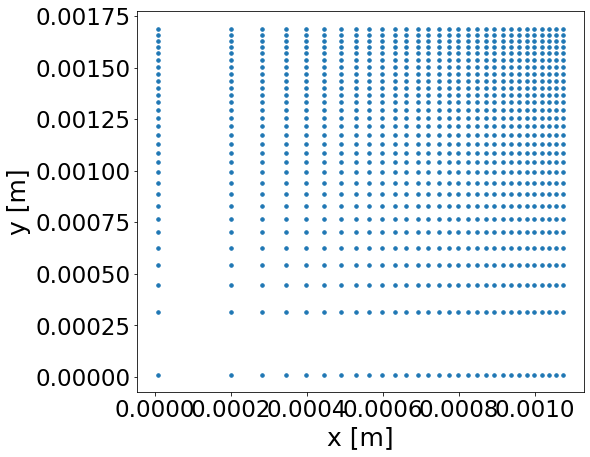

In [32]:
plt.plot(bunch.x , bunch.y,  '.')
plt.xlabel('x [m]')
plt.ylabel('y [m]')

In [33]:
# Switch to action angle coordinates
x_n, xp_n = cmpt_normalised_coordinates(bunch.x, bunch.xp, beta_x[0], alpha_x[0])
y_n, yp_n = cmpt_normalised_coordinates(bunch.y, bunch.yp, beta_y[0], alpha_y[0])


Jx, Jy = cmpt_actions(x_n, xp_n), cmpt_actions(y_n, yp_n)

In [34]:
Qx_incoherent_analytical = amplitude_detuning_x(Jx, Jy, app_x, app_xy)
Qy_incoherent_analytical = amplitude_detuning_y(Jx, Jy, app_y, app_xy)
print(len(Qy_incoherent_analytical))

900


Text(0, 0.5, 'Qy')

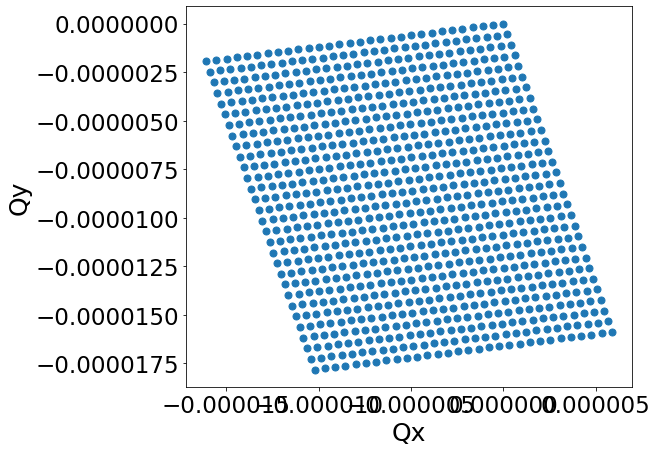

In [35]:
plt.plot(Qx_incoherent_analytical, Qy_incoherent_analytical, 'o')
plt.xlabel('Qx')
plt.ylabel('Qy')

### Apply condition for realistic position of particles.

The probability of particles to have very large Jx and Jy at the same time is very small (botthom left corner).
Thus we apply the following condition:

\begin{equation}
\frac{Jx}{Jx_{max}} + \frac{Jy}{Jy_{max}} \geq 1
\end{equation}

Using this condition we should obtain the familiar triangular footprint.

In [36]:
Jx_max, Jy_max = np.max(Jx), np.max(Jy)
print(Jx_max, Jy_max)

1.9097094849984267e-08 1.933769372919949e-08


In [37]:
Qx_list, Qy_list=[], []
Qx_list_2, Qy_list_2=[], [] 
for particle in range(macroparticlenumber):
    condition = Jx[particle]/Jx_max + Jy[particle]/Jy_max 
    if condition < 1 :
        Qx_list.append(amplitude_detuning_x(Jx[particle], Jy[particle], app_x, app_xy))
        Qy_list.append(amplitude_detuning_y(Jx[particle], Jy[particle], app_y, app_xy))
    else:
        Qx_list_2.append(amplitude_detuning_x(Jx[particle], Jy[particle], app_x, app_xy))
        Qy_list_2.append(amplitude_detuning_y(Jx[particle], Jy[particle], app_y, app_xy))

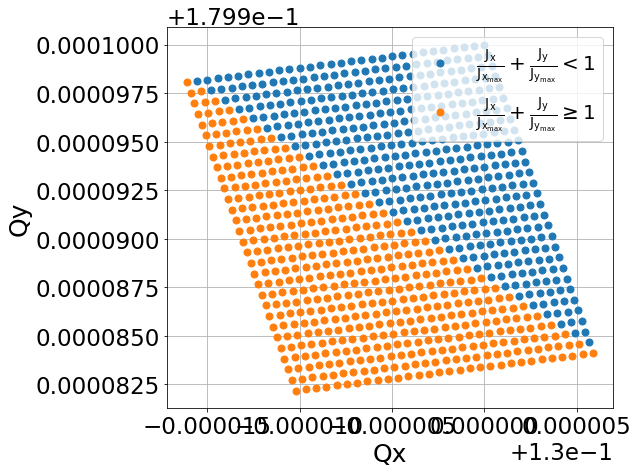

In [38]:
plt.plot(0.13+np.array(Qx_list), 0.18+np.array(Qy_list), 'o', label=r'$\mathrm{\frac{J_x}{J_{x_{max}}}+\frac{J_y}{J_{y_{max}}}} < 1 $')
plt.plot(0.13+np.array(Qx_list_2), 0.18+np.array(Qy_list_2), 'o', label=r'$\mathrm{\frac{J_x}{J_{x_{max}}}+\frac{J_y}{J_{y_{max}}}} \geq 1 $')
plt.xlabel('Qx')
plt.ylabel('Qy')
plt.legend()
plt.grid()

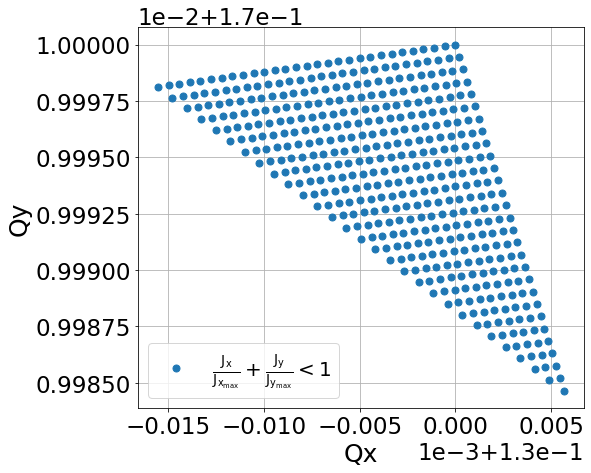

In [50]:
plt.plot(0.13+np.array(Qx_list), 0.18+np.array(Qy_list), 'o', label=r'$\mathrm{\frac{J_x}{J_{x_{max}}}+\frac{J_y}{J_{y_{max}}}} < 1 $')
plt.xlabel('Qx')
plt.ylabel('Qy')
plt.ticklabel_format(axis='y', style='', scilimits=(-2,-2), useOffset=0.17)
plt.ticklabel_format(axis='x', style='', scilimits=(-3,-3), useOffset=0.13)
plt.legend()
plt.grid()

### Cross check with tracking

In [40]:
n_turns = 500 # enough for NAFFlib
decTurns = 1

In [41]:
# Create the transverese and longitudinal map
scale_factor = 2*bunch.p0  # scale the detuning coefficients in pyheadtail units
transverse_map = TransverseMap(s, alpha_x, beta_x, D_x, alpha_y, beta_y, D_y, Q_x, Q_y,
    [Chromaticity(Qp_x, Qp_y),
    AmplitudeDetuning(app_x*scale_factor, app_y*scale_factor, app_xy*scale_factor)])

longitudinal_map = LinearMap([alpha], circumference, Q_s)

In [42]:
# set up the accelerator

one_turn_map = []
for i, segment in enumerate(transverse_map):
    one_turn_map.append(segment)
#one_turn_map.append(longitudinal_map)

n_damped_turns = int(n_turns/decTurns) 

In [43]:
X = {}
Y = {}
meanX = np.zeros(n_damped_turns)
meanY = np.zeros(n_damped_turns)
  
file2 = open(f'bunch1', 'rb')
bunch = pickle.load(file2)
file2.close()   

print('start tracking')    
t0 = time.clock()
for i in range(n_turns):

    #These next two lines actually "run" the simulation - the computationally heavy part
    for m in one_turn_map:
        m.track(bunch)
            
        
    if i%decTurns is  0:
        j = int(i/decTurns)
        X[f'turn {j}'] = bunch.x
        Y[f'turn {j}'] = bunch.y
        meanX[j] = np.mean(bunch.x)
        meanY[j] = np.mean(bunch.y)
dataExport = [X, Y, meanX, meanY]

#f = open(filename+f'.txt', 'w')

#with f:
#    out = csv.writer(f, delimiter=',')
#    out.writerows(zip(*dataExport))

print('--> Done.')

print("Simulation time in seconds: " + str(time.clock() - t0))

start tracking
--> Done.
Simulation time in seconds: 0.1333190000000002


/home/natalia/anaconda3/envs/run_pyheadtail/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()
/home/natalia/anaconda3/envs/run_pyheadtail/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


### COmpute incoherent tune shift from tracking

The following conditon is also met here:
\begin{equation}
\frac{Jx}{Jx_{max}} + \frac{Jy}{Jy_{max}} \geq 1
\end{equation}

In [45]:
Qx_incoherent_tracking = []
Qy_incoherent_tracking = []

for particle in range(macroparticlenumber):
    condition = Jx[particle]/np.max(Jx) + Jy[particle]/np.max(Jy) 
    if condition < 1:
        x_signal = []
        y_signal = []
        for turn in range(n_turns):
            x_signal.append(X[f'turn {turn}'][particle])
            y_signal.append(Y[f'turn {turn}'][particle])


        Qx_incoherent_tracking.append(pnf.get_tune(np.array(x_signal)))
        Qy_incoherent_tracking.append(pnf.get_tune(np.array(y_signal)))

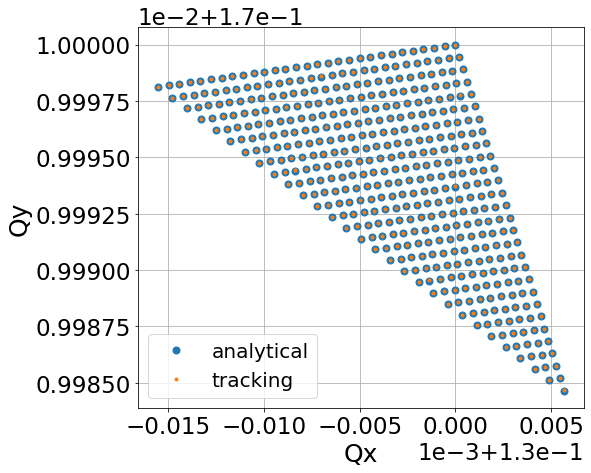

In [51]:
plt.plot(0.13+np.array(Qx_list), 0.18+np.array(Qy_list), 'o', label='analytical')
plt.plot(Qx_incoherent_tracking, Qy_incoherent_tracking, 'o', ms=3, label='tracking')
plt.xlabel('Qx')
plt.ylabel('Qy')
plt.ticklabel_format(axis='y', style='', scilimits=(-2,-2), useOffset=0.17)
plt.ticklabel_format(axis='x', style='', scilimits=(-3,-3), useOffset=0.13)
plt.legend()
plt.grid()

### Compute the coherent tune 

In [52]:
Qx_coherent = pnf.get_tune(meanX)
Qy_coherent = pnf.get_tune(meanY)
print(Qx_coherent, Qy_coherent)

0.12999554565799312 0.17999087246841644


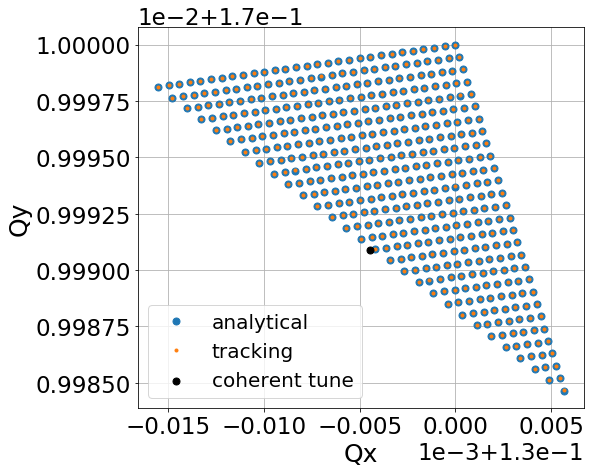

In [54]:
plt.plot(0.13+np.array(Qx_list), 0.18+np.array(Qy_list), 'o', label='analytical')
plt.plot(Qx_incoherent_tracking, Qy_incoherent_tracking, 'o', ms=3, label='tracking')
plt.scatter(Qx_coherent, Qy_coherent, c='k', zorder=50, label='coherent tune')

plt.xlabel('Qx')
plt.ylabel('Qy')
plt.ticklabel_format(axis='y', style='', scilimits=(-2,-2), useOffset=0.17)
plt.ticklabel_format(axis='x', style='', scilimits=(-3,-3), useOffset=0.13)
plt.legend()
plt.grid()